# Quantization

## Post Training Quantization with QKeras

In [1]:
!pip install qkeras

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from qkeras import *
from qkeras.utils import model_quantize
from tensorflow.keras.models import load_model

## Load train and test dataset

In [4]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Load the pre-trained model
The model is trained with jet-tagging open datase: `hls4ml_lhc_jets_hlf`.

We used 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

Look at the **training notebook** to see the details:
https://github.com/ml4fp/2024-lbnl/blob/main/efficient_ml/part1_karas_training.ipynb


In [5]:
model = load_model('baseline_model/KERAS_check_best_model.h5')

2025-08-08 15:54:05.741128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 15:54:06.327246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79047 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0


## Construct a quantized model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

### Config 1:
Using 6 bits for the Dense layers and Activation function

In [6]:
config_1 = {
    "QDense": {
        "kernel_quantizer": "quantized_bits(6,0,alpha=1)",
        "bias_quantizer": "quantized_bits(6,0,alpha=1)",
        "kernel_initializer": "'lecun_uniform'",
        "kernel_regularizer": "l1(0.0001)"
    },
    "QActivation": {"activation": "quantized_relu(6)"}
}
qmodel_1 = model_quantize(model, config_1, 6, transfer_weights=True)

Print the model summary

In [7]:
qmodel_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 64)                1088      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (QDense)                (None, 32)                2080      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (QDense)             (None, 5)                 1

### Config 2:
Using 3 bits for the Dense layers and Activation function

In [8]:
config_2 = {
    "QDense": {
        "kernel_quantizer": "quantized_bits(3,0,alpha=1)",
        "bias_quantizer": "quantized_bits(3,0,alpha=1)",
        "kernel_initializer": "'lecun_uniform'",
        "kernel_regularizer": "l1(0.0001)"
    },
    "QActivation": {"activation": "quantized_relu(3)"}
}
qmodel_2 = model_quantize(model, config_2, 3, transfer_weights=True)

## Model prediction
The quantized  models are used for evaluation

In [9]:
y_qkeras_1 = qmodel_1.predict(np.ascontiguousarray(X_test))

 196/5188 [>.............................] - ETA: 3s     

2025-08-08 15:54:08.616212: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5188/5188 [==============================] - 5s 755us/step


In [10]:
y_qkeras_2 = qmodel_2.predict(np.ascontiguousarray(X_test))

5188/5188 [==============================] - 4s 764us/step


## Check performance
Check the accuracy and make a ROC curve

5188/5188 [==============================] - 3s 581us/step
Accuracy baseline:  0.7502831325301205
Accuracy quantized (nbit = 6): 0.7488433734939759
Accuracy quantized (nbit = 3): 0.6136746987951808


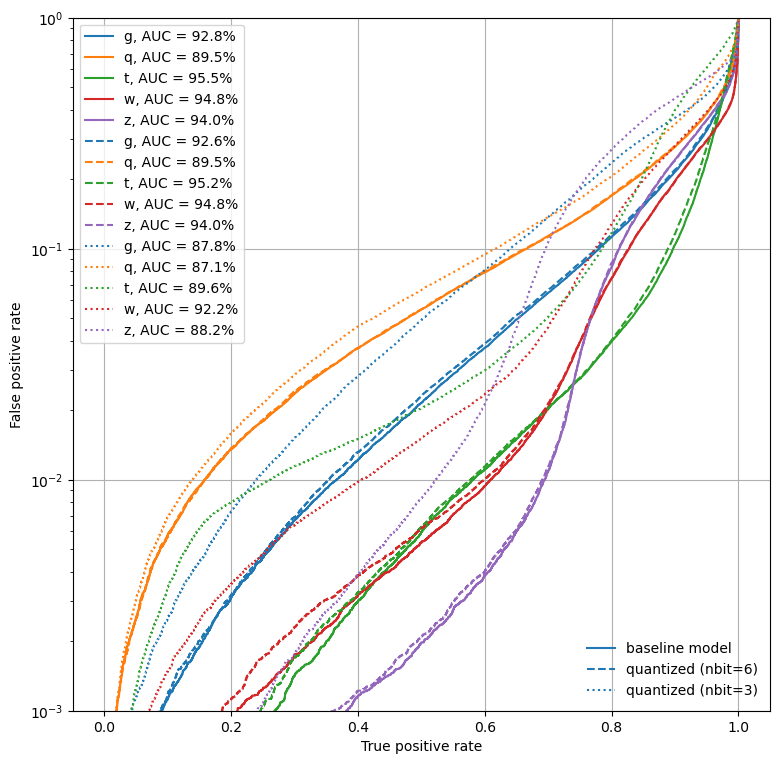

In [11]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import plotting


model_ref = load_model('baseline_model/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy quantized (nbit = 6): {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras_1, axis=1))))
print("Accuracy quantized (nbit = 3): {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras_2, axis=1))))


fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.make_roc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.make_roc(y_test, y_qkeras_1, classes, linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.make_roc(y_test, y_qkeras_2, classes, linestyle=':')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['baseline model', 'quantized (nbit=6)', 'quantized (nbit=3)'],
            loc='lower right', frameon=False)
ax.add_artist(leg)